# DICOM 2D

## Objectives

Given a dynamic renal study from a gamma camera in DICOM format (available from https://dynamicrenalstudy.org/browse#).

The files are:

* drsprg_114_ANT.dcm (anterior acquisition)
* drsprg_114_POST.dcm (posterior acquisition)

A) Calculate the following using appropriate tags from the file:
1. Pixel size
2. Date and time of the examination
3. Manufacturer of the imaging system
4. Number of frames
5. Radioisotope used
6. Permissible energy window (keV) (search for Tag '0054', '0012'). Comment on the window boundaries.
7. Exposure time
8. Maximum pixel value

B) Define a region of interest (ROI) for each of the 2 kidneys, as well as an ROI for the background.
Calculate and plot:
1. Activity curve for each kidney, before and after background correction, for both posterior and anterior acquisitions.
2. Propose a method for combining the 2 acquisitions into a single acquisition.

## Import Packages

In [22]:
import pydicom
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Load files

In [23]:
# Path
ant_file_path = 'drsprg_114_ANT.dcm'
post_file_path = 'drsprg_114_POST.dcm'

# Read DICOM files
ant_dataset = pydicom.dcmread(ant_file_path)
post_dataset = pydicom.dcmread(post_file_path)

## A) Handling File Tags

For finding the tags, the [DICOM Library](https://www.dicomlibrary.com/dicom/dicom-tags/) website was used.

The notation "N/A" stands for Not Available.


In [24]:
# Function to print DICOM tags
def print_dicom_tags(dataset):
    print("1. Pixel size:", dataset.get((0x0028, 0x0030), "N/A"))
    print("2. Date and time of examination:", dataset.get((0x0008, 0x0020), "N/A"), dataset.get((0x0008, 0x0030), "N/A"))
    print("3. Manufacturer of imaging system:", dataset.get((0x0008, 0x0070), "N/A"))
    print("4. Number of frames:", dataset.get((0x0028, 0x0008), "N/A"))
    
    radiopharmaceutical_info_sequence = dataset.get((0x0054, 0x0016), None)
    radiopharmaceutical = radiopharmaceutical_info_sequence[0].get((0x0054, 0x0018), "N/A") if radiopharmaceutical_info_sequence else "N/A"
    print("5. Radioisotope:", radiopharmaceutical)

    energy_window = dataset.get((0x0054, 0x0012), "N/A")
    print("6. Permissible energy window (keV):", energy_window)
    
    if energy_window != "N/A":
        print("   Window boundaries:", dataset.get((0x0054, 0x0016), "N/A"))
    
    print("7. Exposure time:", dataset.get((0x0008, 0x0031), "N/A"))
    print("8. Maximum pixel value:", dataset.get((0x0028, 0x0107), "N/A"))


# Read DICOM files
ant_dataset = pydicom.dcmread(ant_file_path)
post_dataset = pydicom.dcmread(post_file_path)

# Print DICOM tags for Anterior
print("\nANT:")
print_dicom_tags(ant_dataset)

# Print DICOM tags for Posterior
print("\nPOST:")
print_dicom_tags(post_dataset)



ANT:
1. Pixel size: (0028, 0030) Pixel Spacing                       DS: [3.319913, 3.319913]
2. Date and time of examination: (0008, 0020) Study Date                          DA: '20090831' (0008, 0030) Study Time                          TM: '074618.00'
3. Manufacturer of imaging system: (0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'
4. Number of frames: (0028, 0008) Number of Frames                    IS: '180'
5. Radioisotope: N/A
6. Permissible energy window (keV): (0054, 0012) Energy Window Information Sequence  SQ: <Sequence, length 1>
   Window boundaries: (0054, 0016) Radiopharmaceutical Information Seq SQ: <Sequence, length 1>
7. Exposure time: (0008, 0031) Series Time                         TM: '075334.00'
8. Maximum pixel value: (0028, 0107) Largest Image Pixel Value           US: 67

POST:
1. Pixel size: (0028, 0030) Pixel Spacing                       DS: [3.319913, 3.319913]
2. Date and time of examination: (0008, 0020) Study Date            

## B) 

#### Display every frame

In [25]:
def print_number_of_frames(dataset, description):
    print(f"{description} has {len(dataset.pixel_array)} frames.")

def plot_all_frames(dataset, description):
    num_frames = len(dataset.pixel_array)
    num_cols = 10  # Set the number of columns in the subplot
    num_rows = -(-num_frames // num_cols)  # Calculate the number of rows needed

    plt.figure(figsize=(20, 4 * num_rows))

    for i, frame in enumerate(dataset.pixel_array, 1):
        plt.subplot(num_rows, num_cols, i), plt.imshow(frame, cmap='gray'), plt.title(f'{description} Frame {i}')

    plt.tight_layout()
    plt.show()

# Plot all frames for each file
#plot_all_frames(ant_dataset, "Anterior")
#plot_all_frames(post_dataset, "Posterior")


#### 1)

First, the bounding boxes are created using user interface.

In [26]:
# Enable Tkinter-based interactive plotting
%matplotlib tk

# Define variables to store ROIs
ant_roi1 = None
ant_roi2 = None
post_roi1 = None
post_roi2 = None

# Function to get user input for ROI
def get_roi_from_user(image, description):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Select 4 points for {description} ROI (clockwise starting from top-left)')
    plt.axis('on')
    points = plt.ginput(4, timeout=-1)  # Allow the user to click 4 points
    plt.close(fig)

    # Convert points to rectangle coordinates
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    x_min, x_max, y_min, y_max = int(min(x)), int(max(x)), int(min(y)), int(max(y))

    return (x_min, y_min, x_max - x_min, y_max - y_min)

# Function to plot the last frame with user-defined bounding boxes
def plot_last_frame_with_user_boxes(dataset, description):
    global ant_roi1, ant_roi2, post_roi1, post_roi2

    last_frame = dataset.pixel_array[-1].copy()

    # Get user input for ROI 1
    if description == "Anterior":
        ant_roi1 = get_roi_from_user(last_frame, description)
    elif description == "Posterior":
        post_roi1 = get_roi_from_user(last_frame, description)
    
    # Create a transparent overlay for ROI 1
    overlay1 = last_frame.copy()
    x1, y1, w1, h1 = ant_roi1 if description == "Anterior" else post_roi1
    cv2.rectangle(overlay1, (x1, y1), (x1+w1, y1+h1), (255, 255, 255), 2)

    # Get user input for ROI 2
    if description == "Anterior":
        ant_roi2 = get_roi_from_user(last_frame, description)
    elif description == "Posterior":
        post_roi2 = get_roi_from_user(last_frame, description)
    
    # Create a transparent overlay for ROI 2
    overlay2 = last_frame.copy()
    x2, y2, w2, h2 = ant_roi2 if description == "Anterior" else post_roi2
    cv2.rectangle(overlay2, (x2, y2), (x2+w2, y2+h2), (255, 255, 255), 2)

    # Plot the last frame with user-defined bounding boxes
    plt.figure(figsize=(10, 8))

    # Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(last_frame, cmap='gray')
    plt.title(f'{description} Last Frame')

    # Image with Bounding Box 1
    plt.subplot(2, 2, 2)
    overlay1_with_transparency = cv2.addWeighted(overlay1, 0.1, last_frame, 0.99, 0)
    plt.imshow(overlay1_with_transparency, cmap='gray')
    plt.title(f'{description} Last Frame with Bounding Box 1')

    # Image with Bounding Box 2
    plt.subplot(2, 2, 3)
    overlay2_with_transparency = cv2.addWeighted(overlay2, 0.1, last_frame, 0.99, 0)
    plt.imshow(overlay2_with_transparency, cmap='gray')
    plt.title(f'{description} Last Frame with Bounding Box 2')

    # Image with Both Bounding Boxes
    plt.subplot(2, 2, 4)
    overlay_both = last_frame.copy()
    cv2.rectangle(overlay_both, (x1, y1), (x1+w1, y1+h1), (255, 255, 255), 2)
    cv2.rectangle(overlay_both, (x2, y2), (x2+w2, y2+h2), (255, 255, 255), 2)
    overlay_both_with_transparency = cv2.addWeighted(overlay_both, 0.1, last_frame, 0.99, 0)
    plt.imshow(overlay_both_with_transparency, cmap='gray')
    plt.title(f'{description} Last Frame with Both Bounding Boxes')

    plt.tight_layout()
    plt.show()
    plt.close()

# Plot the last frame with user-defined bounding boxes for each file
plot_last_frame_with_user_boxes(ant_dataset, "Anterior")
plot_last_frame_with_user_boxes(post_dataset, "Posterior")


Then, the selected bounding boxes are applied on every frame.

In [27]:
# Enable inline plotting
%matplotlib inline

# Function to plot all frames with selected bounding boxes
def plot_all_frames_with_selected_boxes(dataset, description, roi1, roi2):
    num_frames = len(dataset.pixel_array)
    num_cols = 10  # Set the number of columns in the subplot
    num_rows = -(-num_frames // num_cols)  # Calculate the number of rows needed

    plt.figure(figsize=(20, 4 * num_rows))

    for i, frame in enumerate(dataset.pixel_array, 1):
        # Create transparent overlays for selected bounding boxes
        overlay1 = frame.copy()
        x1, y1, w1, h1 = roi1
        cv2.rectangle(overlay1, (x1, y1), (x1+w1, y1+h1), (255, 255, 255), 2)

        overlay2 = frame.copy()
        x2, y2, w2, h2 = roi2
        cv2.rectangle(overlay2, (x2, y2), (x2+w2, y2+h2), (255, 255, 255), 2)

        # Combine the original image with the overlays
        overlay_both = frame.copy()
        cv2.rectangle(overlay_both, (x1, y1), (x1+w1, y1+h1), (255, 255, 255), 2)
        cv2.rectangle(overlay_both, (x2, y2), (x2+w2, y2+h2), (255, 255, 255), 2)

        overlay_both_with_transparency = cv2.addWeighted(overlay_both, 0.1, frame, 0.99, 0)

        # Plot the frame with both bounding boxes
        plt.subplot(num_rows, num_cols, i)
        plt.imshow(overlay_both_with_transparency, cmap='gray')
        plt.title(f'{description} Frame {i} ')

    plt.tight_layout()
    plt.show()

# Use the selected bounding boxes for all frames
#plot_all_frames_with_selected_boxes(ant_dataset, "Anterior", ant_roi1, ant_roi2)
#plot_all_frames_with_selected_boxes(post_dataset, "Posterior", post_roi1, post_roi2)


The Activity Curves are then created.

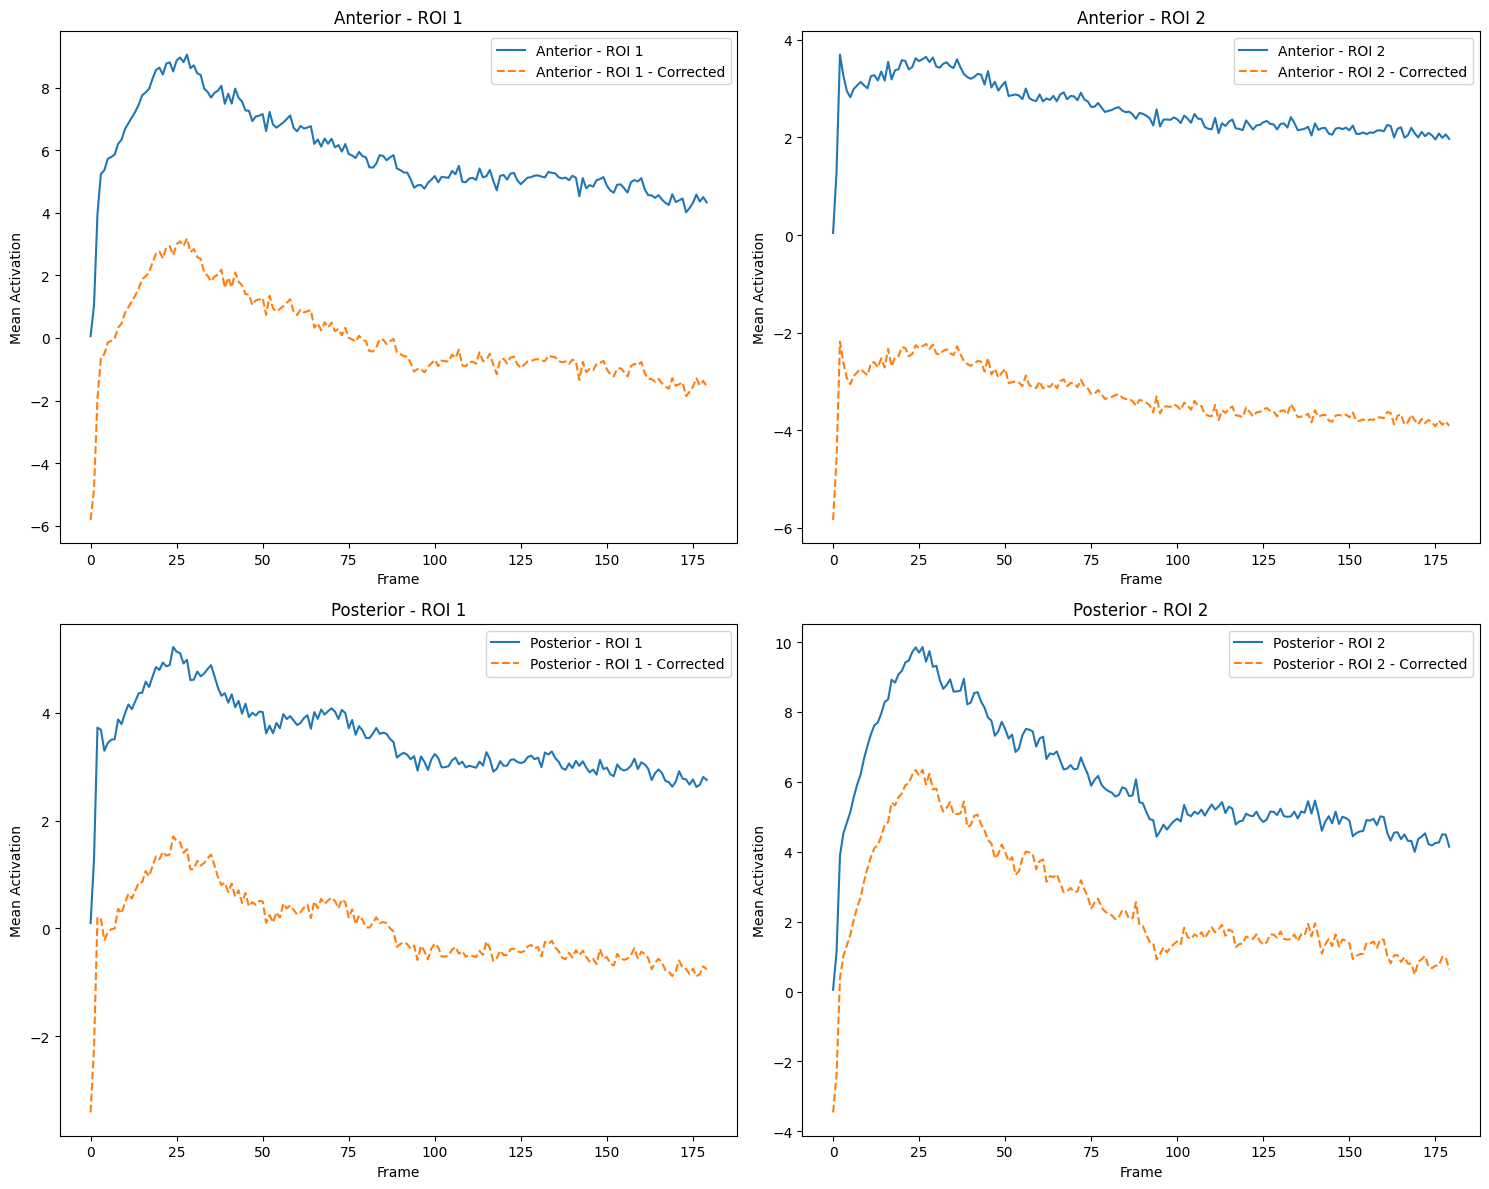

In [28]:
# Define your functions

def calculate_mean_activation(frames, roi):
    activations = []

    for frame in frames:
        x, y, w, h = roi
        roi_values = frame[y:y+h, x:x+w]
        mean_activation = np.mean(roi_values)
        activations.append(mean_activation)

    return activations

def correct_background(frames, roi):
    corrected_frames = []

    # Calculate background mean
    background_mean = np.mean([frame[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]] for frame in frames])

    # Correct each frame
    for frame in frames:
        corrected_frame = frame - background_mean
        corrected_frames.append(corrected_frame)

    return corrected_frames

# Calculate activations for each ROI
ant_activation_curve_roi1 = calculate_mean_activation(ant_dataset.pixel_array, ant_roi1)
ant_activation_curve_roi2 = calculate_mean_activation(ant_dataset.pixel_array, ant_roi2)

post_activation_curve_roi1 = calculate_mean_activation(post_dataset.pixel_array, post_roi1)
post_activation_curve_roi2 = calculate_mean_activation(post_dataset.pixel_array, post_roi2)

# Correct background for each dataset
ant_dataset_corrected = correct_background(ant_dataset.pixel_array, ant_roi1)
post_dataset_corrected = correct_background(post_dataset.pixel_array, post_roi1)

# Calculate activations after correction
ant_activation_curve_corrected_roi1 = calculate_mean_activation(ant_dataset_corrected, ant_roi1)
ant_activation_curve_corrected_roi2 = calculate_mean_activation(ant_dataset_corrected, ant_roi2)

post_activation_curve_corrected_roi1 = calculate_mean_activation(post_dataset_corrected, post_roi1)
post_activation_curve_corrected_roi2 = calculate_mean_activation(post_dataset_corrected, post_roi2)

# Display activation curves for each ROI
plt.figure(figsize=(15, 12))

# Anterior ROI 1
plt.subplot(2, 2, 1)
plt.plot(ant_activation_curve_roi1, label='Anterior - ROI 1')
plt.plot(ant_activation_curve_corrected_roi1, label='Anterior - ROI 1 - Corrected', linestyle='dashed')
plt.xlabel('Frame')
plt.ylabel('Mean Activation')
plt.title('Anterior - ROI 1')
plt.legend()

# Anterior ROI 2
plt.subplot(2, 2, 2)
plt.plot(ant_activation_curve_roi2, label='Anterior - ROI 2')
plt.plot(ant_activation_curve_corrected_roi2, label='Anterior - ROI 2 - Corrected', linestyle='dashed')
plt.xlabel('Frame')
plt.ylabel('Mean Activation')
plt.title('Anterior - ROI 2')
plt.legend()

# Posterior ROI 1
plt.subplot(2, 2, 3)
plt.plot(post_activation_curve_roi1, label='Posterior - ROI 1')
plt.plot(post_activation_curve_corrected_roi1, label='Posterior - ROI 1 - Corrected', linestyle='dashed')
plt.xlabel('Frame')
plt.ylabel('Mean Activation')
plt.title('Posterior - ROI 1')
plt.legend()

# Posterior ROI 2
plt.subplot(2, 2, 4)
plt.plot(post_activation_curve_roi2, label='Posterior - ROI 2')
plt.plot(post_activation_curve_corrected_roi2, label='Posterior - ROI 2 - Corrected', linestyle='dashed')
plt.xlabel('Frame')
plt.ylabel('Mean Activation')
plt.title('Posterior - ROI 2')
plt.legend()

plt.tight_layout()
plt.show()

#### 2) Combining Images

Since one acquisition is anterior and the other is posterior, the images from the posterior acquisition should initially undergo a horizontal flip. Then, each frame of the anterior acquisition will be added to the corresponding frame of the posterior acquisition with a horizontal flip. The last frame from each acquisition will be selected for visualization separately.

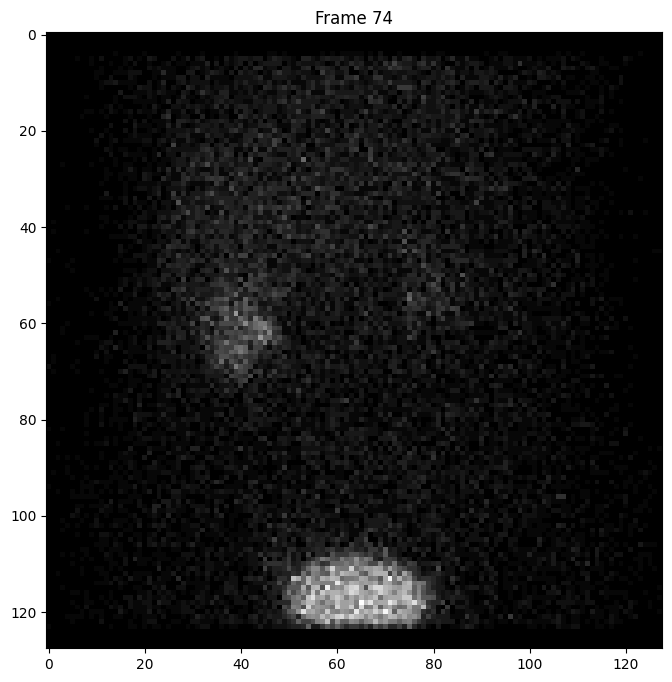

In [29]:
# Function to flip frames horizontally
def flip_frames_horizontally(frames):
    return [cv2.flip(frame, 1) for frame in frames]

# Function to plot all frames for each file with the specified modifications
def plot_all_frames_modified(ant_dataset, post_dataset, description):
    # Flip frames of the posterior dataset horizontally
    post_dataset_flipped = flip_frames_horizontally(post_dataset.pixel_array)

    # Add corresponding frames of the anterior and flipped posterior datasets
    combined_frames = [cv2.addWeighted(ant_frame, 0.01, post_frame, 0.01, 0)
                       for ant_frame, post_frame in zip(ant_dataset.pixel_array, post_dataset_flipped)]

    # Combine all frames
    all_frames = ant_dataset.pixel_array + combined_frames

    # Plot all frames
    #num_frames = len(all_frames)
    #num_cols = 10
    #num_rows = -(-num_frames // num_cols)

    #plt.figure(figsize=(20, 4 * num_rows))

    #for i, frame in enumerate(all_frames, 1):
    #    plt.subplot(num_rows, num_cols, i)
    #    plt.imshow(frame, cmap='gray')
    #    plt.title(f'Frame {i}')

    #plt.tight_layout()
    #plt.show()

    # Plot the 74th frame separately
    plt.figure(figsize=(8, 8))
    plt.imshow(all_frames[73], cmap='gray')
    plt.title(f'Frame 74')
    plt.show()

# Plot all frames for each file with the specified modifications
plot_all_frames_modified(ant_dataset, post_dataset, "Combined")